<img src="./img/oscon.png" width="400">

# Abstraction layers 

# contrib.learn

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.constant(0))

0

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/gpu:0']

# Estimators
### 1. Instantiate the Estimator class
~~~python 
model = learn.Estimator()
~~~
### 2.  Fit it using training data
~~~python 
model.fit()
~~~
### 3. Evaluate how good is the fit
~~~python 
model.evaluate()
~~~
### 4. Predict outcomes on new data
~~~python 
model.predict()
~~~



# Deep Neural Network Estimator

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib import layers
learn = tf.contrib.learn
import numpy as np

tf.logging.set_verbosity(tf.logging.ERROR)

DATA_DIR = '/tmp/data'
data = input_data.read_data_sets(DATA_DIR, one_hot=False)
x_data, y_data = data.train.images,data.train.labels.astype(np.int32)
x_test, y_test = data.test.images,data.test.labels.astype(np.int32)
feature_columns = [tf.contrib.layers.real_valued_column("")]

# Or estimator using the ProximalAdagradOptimizer optimizer with
# regularization.
estimator = learn.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[50],
    n_classes=10,
    optimizer=tf.train.ProximalAdagradOptimizer(
      learning_rate=0.2,
    ))

# estimator.fit(input_fn=lambda:input_fn(x_data,y_data), steps=2)
estimator.fit(x=x_data,y=y_data, steps=500,batch_size=128)



Extracting /tmp/data\train-images-idx3-ubyte.gz
Extracting /tmp/data\train-labels-idx1-ubyte.gz
Extracting /tmp/data\t10k-images-idx3-ubyte.gz
Extracting /tmp/data\t10k-labels-idx1-ubyte.gz


C:\p3\lib\site-packages\tensorflow\python\util\deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x00000298DC541630>, 'dropout': None, 'activation_fn': <function relu at 0x00000298D99C9268>, 'embedding_lr_multipliers': None, 'hidden_units': [50], 'input_layer_min_slice_size': None, 'feature_columns': (_RealValuedColumn(column_name='', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': <tensorflow.python.training.proximal_adagrad.ProximalAdagradOptimizer object at 0x00000298DBF858D0>, 'gradient_clip_norm': None})

In [5]:
ev = estimator.evaluate(x=x_test,y=y_test, steps=1)["accuracy"]
print(ev)

C:\p3\lib\site-packages\tensorflow\python\util\deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


0.9549


### Logistic Regression from day 1

### Using a custom Estimator

In [337]:
learn = tf.contrib.learn


# Input builders
def input_fn(x_data,y_data):
        
    feature_cols = {}
    feature_cols['x_data'] = tf.constant(x_data,dtype=tf.float32)    
    labels = tf.constant(y_data,dtype=tf.float32)
    
    x = tf.contrib.layers.real_valued_column('x_data')
    
    feature_cols = tf.contrib.layers.input_from_feature_columns(
    columns_to_tensors=feature_cols, feature_columns=[x])
    
    return feature_cols, labels

def feature_engineering_fn(feature_cols, labels):
    "Do some prepreocessing here"
    return feature_cols, labels
    

def my_model_fn(x_data,y_data,mode,params):

    w = tf.Variable([[0,0,0]],dtype=tf.float32,name='w')
    b = tf.Variable(0,dtype=tf.float32,name='b')
    predictions = tf.sigmoid(tf.matmul(w,tf.transpose(x_data)) + b)
    
    loss_tmp = - y_data * tf.log(predictions) - (1.0 - y_data) * tf.log(1.0 - predictions)
    loss = tf.reduce_mean(loss_tmp)
    
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=params["learning_rate"],
        optimizer="Adagrad")
    
    return predictions, loss, train_op


In [339]:
model_params = {"learning_rate": 0.5}
est = learn.Estimator(model_fn=my_model_fn,\
                      feature_engineering_fn=feature_engineering_fn,\
                      params=model_params,\
                      model_dir='tmp/',\
                      config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1))
est.fit(input_fn=lambda:input_fn(x_data,y_data),steps=50)

print est.get_variable_names()

w_w = est.get_variable_value('w')
print 'Estimation for w: {}'.format(w_w)

b = est.get_variable_value('b')
print 'Estimation for b: {}'.format(b)


INFO:tensorflow:Using config: {'save_summary_steps': 100, '_num_ps_replicas': 0, '_task_type': None, '_environment': 'local', '_is_chief': True, 'save_checkpoints_secs': 1, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f53bf525e10>, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, 'tf_random_seed': None, 'keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', 'save_checkpoints_steps': None, '_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:loss = 0.693147, step = 1
INFO:tensorflow:Saving checkpoints for 1 into tmp/model.ckpt.
INFO:tensorflow:Saving checkpoints for 50 into tmp/model.ckpt.
INFO:tensorflow:Loss for final step: 0.648008.
['OptimizeLoss/b/Adagrad', 'OptimizeLoss/learning_rate', 'OptimizeLoss/w/Adagrad', 'b', 'global_step', 'w']
Estimation for w: [[ 0.30287072  0.52123469  0.08164342]]
Estimation for b: -0.203406557441


In [561]:
import numpy as np
N = 10000

# generate data

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# === Create data and simulate results =====
x_data = np.random.randn(N,3)
w_real = [0.3,0.5,0.1]
bias = [-1.2,0,1.2]

category_id = np.random.randint(0,3,N)


noise = np.random.randn(1,N)*0.1
wx = np.matmul(w_real,x_data.T) 
wxb = np.array([wx[i]+bias[b]for i,b in enumerate(category_id)])

category_names = ['computers','food','clothes']
category = np.array([category_names[s] for s in category_id])

y_data_pre_noise = sigmoid(wxb)
y_data = np.random.binomial(1,y_data_pre_noise)

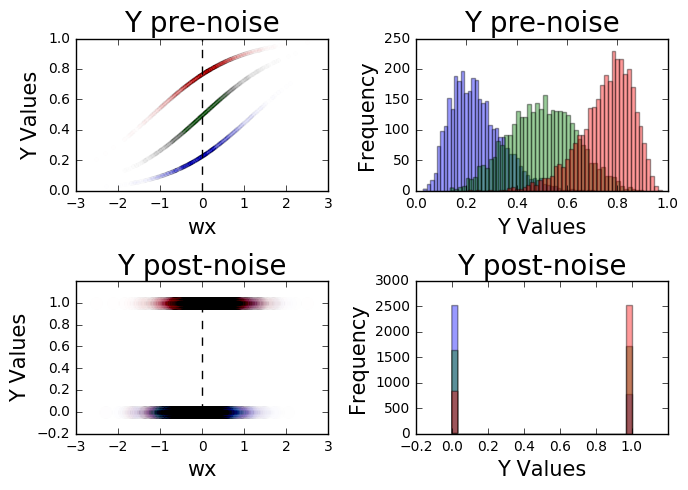

In [562]:
# plot

f,axarr = plt.subplots(2,2,figsize=[7,5])
ax = axarr[0,0]
for cat in category_names:
    ax.plot(wx[category==cat],y_data_pre_noise[category==cat],'o',ms=3,alpha=0.005)
ax.plot([0,0],[0,1],'k--')

ax.set_xlim([-3,3])
ax.set_title('Y pre-noise',fontsize=20)
ax.set_ylabel('Y Values',fontsize=15)
ax.set_xlabel('wx',fontsize=15)

ax = axarr[0,1]
for cat in category_names:
    ax.hist(y_data_pre_noise[category==cat],50,alpha=0.4)
ax.set_title('Y pre-noise',fontsize=20)
ax.set_xlim([0,1])
ax.set_ylabel('Frequency',fontsize=15)
ax.set_xlabel('Y Values',fontsize=15)

ax = axarr[1,0]
for cat in category_names:
    ax.plot(wx[category==cat],y_data[category==cat],'o',ms=9,alpha=0.003)
ax.plot([0,0],[0,1],'k--')
ax.set_xlim([-3,3])
ax.set_ylim([-0.2,1.2])
ax.set_title('Y post-noise',fontsize=20)
ax.set_ylabel('Y Values',fontsize=15)
ax.set_xlabel('wx',fontsize=15)

ax = axarr[1,1]
for cat in category_names:
    ax.hist(y_data[category==cat],30,alpha=0.4)
ax.set_title('Y post-noise',fontsize=20)
ax.set_xlim([-0.2,1.2])
ax.set_ylabel('Frequency',fontsize=15)
ax.set_xlabel('Y Values',fontsize=15)


plt.tight_layout()
plt.show()

In [563]:
import pandas as pd
df = pd.DataFrame({'bias':category,'x1':x_data[:,0],'x2':x_data[:,1],'x3':x_data[:,2],'target':y_data})
cols = df.columns.tolist()
cols = [cols[2],cols[3],cols[4],cols[0],cols[1]]
df = df[cols]
df[:9]

,x1,x2,x3,bias,target
0,0.450336,-0.122358,-0.611658,computers,0
1,0.795815,0.950255,0.385978,clothes,1
2,0.647850,-1.561874,1.102416,clothes,1
3,-0.494595,1.088808,0.242360,clothes,0
4,-0.713762,-0.083039,-0.414681,food,0
5,0.479643,-0.567802,1.025886,food,1
6,-0.865113,-1.050168,0.501369,food,0
7,-1.095082,0.649803,-0.530370,computers,0
8,-0.978045,1.526915,0.462523,computers,1


In [596]:
learn = tf.contrib.learn


# Input builders
def input_fn(x_data,category,y_data):
        
    feature_cols = {}
    feature_cols['x_data'] = tf.constant(x_data,dtype=tf.float32)    
    x = tf.contrib.layers.real_valued_column('x_data')


    labels = tf.constant(y_data,dtype=tf.float32)
    
    
    feature_cols['category'] = tf.SparseTensor(
    indices=[[i, 0] for i in range(category.size)],
    values=category, shape=[category.size, 1])
    
    # see what's the order
    print list(feature_cols)
    
    cat=tf.contrib.layers.sparse_column_with_keys(
    column_name='category', keys=category_names)
    
#     cat = tf.contrib.layers.embedding_column(cat,3)
    cat = tf.contrib.layers.one_hot_column(cat)
    
    feature_cols = tf.contrib.layers.input_from_feature_columns(
    columns_to_tensors=feature_cols, feature_columns=[x,cat])
    
    return feature_cols, labels

def feature_engineering_fn(feature_cols, labels):
    "Do some prepreocessing here"
    return feature_cols, labels
    

def my_model_fn(feature_cols,y_data,mode,params):
    print feature_cols
    print feature_cols[:,3:]

    w_x = tf.Variable([[0,0,0]],dtype=tf.float32,name='w_x')
    w_cat = tf.Variable([[0,0,0]],dtype=tf.float32,name='w_cat')
    b = tf.Variable(0,dtype=tf.float32,name='b')

#     b = tf.Variable(0,dtype=tf.float32,name='b')
    predictions = tf.sigmoid(tf.matmul(w_cat,tf.transpose(feature_cols[:,:3]))+\
                             tf.matmul(w_x,tf.transpose(feature_cols[:,3:])))
    
    loss_tmp = - y_data * tf.log(predictions) - (1.0 - y_data) * tf.log(1.0 - predictions)
    loss = tf.reduce_mean(loss_tmp)
    
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=params["learning_rate"],
        optimizer="Adagrad")
    
    return predictions, loss, train_op


In [597]:
tf.logging.set_verbosity(tf.logging.ERROR)

model_params = {"learning_rate": 0.5}
est = learn.Estimator(model_fn=my_model_fn,\
                      feature_engineering_fn=feature_engineering_fn,\
                      params=model_params,\
                      config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1))
#                       model_dir='tmp/',\

est.fit(input_fn=lambda:input_fn(x_data,category,y_data),steps=100)

print est.get_variable_names()

w_x= est.get_variable_value('w_x')
print 'Estimation for w_x: {}'.format(w_x)

w_cat = est.get_variable_value('w_cat')
print 'Estimation for w_Cat: {}'.format(w_cat)


['category', 'x_data']
Tensor("input_from_feature_columns/concat:0", shape=(10000, 6), dtype=float32)
Tensor("strided_slice:0", shape=(10000, 3), dtype=float32)
['OptimizeLoss/learning_rate', 'OptimizeLoss/w_cat/Adagrad', 'OptimizeLoss/w_x/Adagrad', 'b', 'global_step', 'w_cat', 'w_x']
Estimation for w_x: [[ 0.29628426  0.49829358  0.07691273]]
Estimation for w_Cat: [[-1.2332648   0.04924452  1.18695343]]


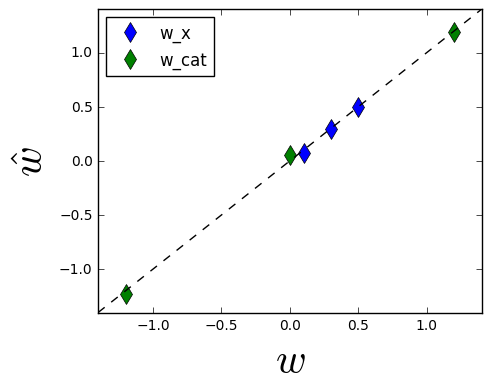

In [636]:
f,axarr = plt.subplots(1,figsize=[5,4])
ax = axarr
ax.plot([0.3,0.5,0.1],w_x[0],'d',ms=10)
ax.plot([-1.2,0,1.2],w_cat[0],'d',ms=10)
ax.plot([-1.4,1.4],[-1.4,1.4],'k--')
ax.axis([-1.4,1.4,-1.4,1.4])
ax.set_ylabel(r'$\hat{w}$',fontsize=30)
ax.set_xlabel(r'$w$',fontsize=30)
ax.legend(['w_x','w_cat'],loc=2,numpoints=1)
plt.tight_layout()
plt.show()

## Keras
Keras is one of the most popular and powerful TensorFlow extension libraries. In 2017 Keras gained official Google support, and will be moved into tf.contrib in the near future.

Keras has two main types of models to choose —Sequential and functional. The sequential type is designed for simple architectures, where we just want to stack layers in a linear fashion. The functional API can support more general models with a diverse layer structure such as multi-output models or a directed acyclic graph. 

# Installation

~~~python 
pip install keras
~~~

Or download from:
[Git page](https://github.com/fchollet/keras)

And install using:

~~~python 
python setup.py install
~~~


# Sequential model



### Dense layer
Dense" is a fully connected layer where the first argument denotes the number of output units and the input shape is the shape of the input (in this example the weight matrix would be of size 784x64). 



~~~python 
from keras.models import Sequential
from keras.layers import Dense, Activation 

model = Sequential()

model.add(Dense(units=64, input_dim=784))
model.add(Activation('softmax')~~~


Learning configurations are using 
~~~python 
.complie() 
~~~
It receives three arguments: the loss function, optimizer and another metric function that is used to judge the performance of your model.

~~~python 
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])~~~

set the optimizer

~~~python 
optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.8, nesterov=True))
~~~

And finally we feed .fit() the data and set the number of epochs and batch_size. As with the previous libraries, we can now easily evaluate how it does and perform prediction with new test data.

Note that a "callbacks" argument was added to the fit method. Callbacks are functions that are a applied during the training procedure, and we can use them to get a view on statistics and make dynamic training decisions by passing a list of them to the ,fit() method.

In this example we plug in two callbacks: (1) TensorBoard, specifying its output folder, and (2) early stopping, where we specify the minimum changed to be monitored (min_delta), the number of no-improvement epochs to stop after (patience) and the direction of wanted change (mode), set here to be inferred automatically.

~~~python 
from keras.callbacks import TensorBoard,EarlyStopping,ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

model.fit(x_train, y_train, epochs=10, batch_size=64,
          callbacks=[TensorBoard(log_dir='/models/autoencoder',)
          early_stop])

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
classes = model.predict(x_test, batch_size=64)
~~~



# Functional model
The main difference here is that we first define our input and output, and only then instantiate the model

Create an input Tensor according to its shape

~~~python 
inputs = Input(shape=(784,))
~~~

Define model

~~~python 
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
~~~

And now instantiate the model, passing both inputs and outputs to "Model".

~~~python 
model = Model(inputs=inputs, oprintutputs=outputs)

from keras.callbacks import TensorBoard,EarlyStopping,ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

model.fit(x_train, y_train, epochs=10, batch_size=64,
          callbacks=[TensorBoard(log_dir='/models/autoencoder',)
          early_stop])

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
classes = model.predict(x_test, batch_size=64)
~~~

In [11]:
from keras.layers import LSTM, Dropout
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam


model = Sequential()

rnn_size = 64 # The number of neurons in hidden layers.

window_size = 20 # The number of previous notes (and rests) to use as input to the network 
#at each step (measured in 16th notes). It is helpful to think of this as 
#the fixed width of a piano roll rather than individual events.

OUTPUT_SIZE = 129 # 0-127 notes + 1 for rests

dropout = 0.2 # The normalized percentage (0-1) of weights to randomly turn "off" 
# in each layer during a training step. This is a regularization technique called which helps 
# prevent model overfitting. Recommended values are between 0.2 and 0.5, or 20% and 50%.


learning_rate = 0.5 

grad_clip = 5.0 # Clip backpropagated gradients to this value.


kwargs = dict() 
kwargs['units'] = rnn_size
kwargs['input_shape'] = (window_size, OUTPUT_SIZE)

kwargs['return_sequences'] = True
model.add(LSTM(**kwargs))

model.add(LSTM(**kwargs))
model.add(Dropout(dropout))
kwargs['return_sequences'] = True

    
model.add(LSTM(**kwargs))
model.add(Dropout(dropout))
kwargs['return_sequences'] = False

model.add(Dense(OUTPUT_SIZE))
model.add(Activation('softmax'))    

kwargs = { 'clipvalue': grad_clip }

kwargs['lr'] = learning_rate

optimizer = Adam(**kwargs)

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])

print(model.summary())


# load pitch sequences in one-hot encoding

model.fit(x_train, y_train, epochs=10, batch_size=64)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 20, 64)            49664     
_________________________________________________________________
lstm_20 (LSTM)               (None, 20, 64)            33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 20, 64)            33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 64)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 20, 129)           8385      
_________________________________________________________________
activation_6 (Activation)    (None, 20, 129)           0         
Total para

In [ ]:
batch_size = 32 # The number of samples to pass through the network before updating weights.

n_jobs = 1 #The number of CPU cores to use when loading and parsing MIDI files from --data_dir. Increasing this value can dramatically speed up training. I commonly set this value to use all cores, which for my quad-core machine is 8 (Intel CPUs often have 2 virtual cores per CPU).

max_files_in_ram = 25 # Files in --data_dir are loaded into RAM in small batches, processed, and then released to avoid having to load all training files into memory at once (which may be impossible when training on hundreds of files on a machine with limited memory). This value specifies the maximum number of MIDI files to keep in RAM at any one time. Using a larger number significantly speeds up training, however it also runs the risk of using too much RAM and causing your machine to start thrashing or crash. You can find a nice balance by inspecting your system monitor (Activity Monitor on MacOS and Monitor on Ubuntu) while training and adjust accourdingly.

num_epochs = 10 # The number of epochs before completing training. One epoch is equal to one full pass through all midi files




val_split = 0.2 # use 20 percent for validation
val_split_index = int(float(len(midi_files)) * val_split)

# use generators to lazy load train/validation data, ensuring that the
# user doesn't have to load all midi files into RAM at once
train_generator = utils.get_data_generator(midi_files[0:val_split_index], 
                                           window_size=window_size,
                                           batch_size=batch_size,
                                           num_threads=n_jobs,
                                           max_files_in_ram=max_files_in_ram)







val_generator = utils.get_data_generator(midi_files[val_split_index:], 
                                         window_size=args.window_size,
                                         batch_size=args.batch_size,
                                         num_threads=args.n_jobs,
                                         max_files_in_ram=args.max_files_in_ram)




# callbacks = get_callbacks(experiment_dir)

print('fitting model...')
# this is a somewhat magic number which is the average number of length-20 windows
# calculated from ~5K MIDI files from the Lakh MIDI Dataset.
magic_number = 827

start_time = time.time()
model.fit_generator(train_generator,
                    steps_per_epoch=len(midi_files) * magic_number / args.batch_size, 
                    epochs=args.num_epochs,
                    validation_data=val_generator, 
                    validation_steps=len(midi_files) * 0.2 * magic_number / args.batch_size,
                    verbose=1, 
                    initial_epoch=epoch)

print('Finished in {:.2f} seconds'.format(time.time() - start_time))

In [ ]:
def get_data_generator(midi_paths, 
                       window_size=20, 
                       batch_size=32,
                       num_threads=8,
                       max_files_in_ram=170):

    if num_threads > 1:
    	# load midi data
    	pool = ThreadPool(num_threads)

    load_index = 0

    while True:
        load_files = midi_paths[load_index:load_index + max_files_in_ram]
        # print('length of load files: {}'.format(len(load_files)))
        load_index = (load_index + max_files_in_ram) % len(midi_paths)

        # print('loading large batch: {}'.format(max_files_in_ram))
        # print('Parsing midi files...')
        # start_time = time.time()
        if num_threads > 1:
       		parsed = pool.map(parse_midi, load_files)
       	else:
       		parsed = map(parse_midi, load_files)
        # print('Finished in {:.2f} seconds'.format(time.time() - start_time))
        # print('parsed, now extracting data')
        data = _windows_from_monophonic_instruments(parsed, window_size)
        batch_index = 0
        while batch_index + batch_size < len(data[0]):
            # print('getting data...')
            # print('yielding small batch: {}'.format(batch_size))
            
            res = (data[0][batch_index: batch_index + batch_size], 
                   data[1][batch_index: batch_index + batch_size])
            yield res
            batch_index = batch_index + batch_size
        
        # probably unneeded but why not
        del parsed # free the mem
        del data # free the mem

